# Imports

In [1]:
# Standard library imports
import os

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Computer Vision
import cv2

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning (PyTorch)
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# Data 

In [2]:
# Define the path
base_path = '/kaggle/input/plantvillage-dataset/color' # 'color' is the most common folder name

# 1. Get all subdirectories (classes)
classes = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
classes.sort()

# 2. Count images in each class
data_stats = []
for cls in classes:
    count = len(os.listdir(os.path.join(base_path, cls)))
    data_stats.append({"Class": cls, "Count": count})

# 3. Create a DataFrame for visualization
df_stats = pd.DataFrame(data_stats)

## Table

In [3]:
# 1. Calculate Total and Percentages
total_images = df_stats['Count'].sum()
df_stats['Percentage (%)'] = (df_stats['Count'] / total_images) * 100

# 2. Sort by Count (Descending)
df_stats_sorted = df_stats.sort_values(by='Count', ascending=False)

# 3. Display sorted results with Percentages
print(f"Total Images in Dataset: {total_images}")
print(f"Total Classes: {len(classes)}")
print("-" * 50)
# Showing all 38 classes with the new percentage column
print(df_stats_sorted.to_string(index=False, float_format=lambda x: "{:.2f}".format(x)))

Total Images in Dataset: 54305
Total Classes: 38
--------------------------------------------------
                                             Class  Count  Percentage (%)
          Orange___Haunglongbing_(Citrus_greening)   5507           10.14
            Tomato___Tomato_Yellow_Leaf_Curl_Virus   5357            9.86
                                 Soybean___healthy   5090            9.37
                            Peach___Bacterial_spot   2297            4.23
                           Tomato___Bacterial_spot   2127            3.92
                              Tomato___Late_blight   1909            3.52
                           Squash___Powdery_mildew   1835            3.38
                       Tomato___Septoria_leaf_spot   1771            3.26
     Tomato___Spider_mites Two-spotted_spider_mite   1676            3.09
                                   Apple___healthy   1645            3.03
                                  Tomato___healthy   1591            2.93
            

## Distribution of Images

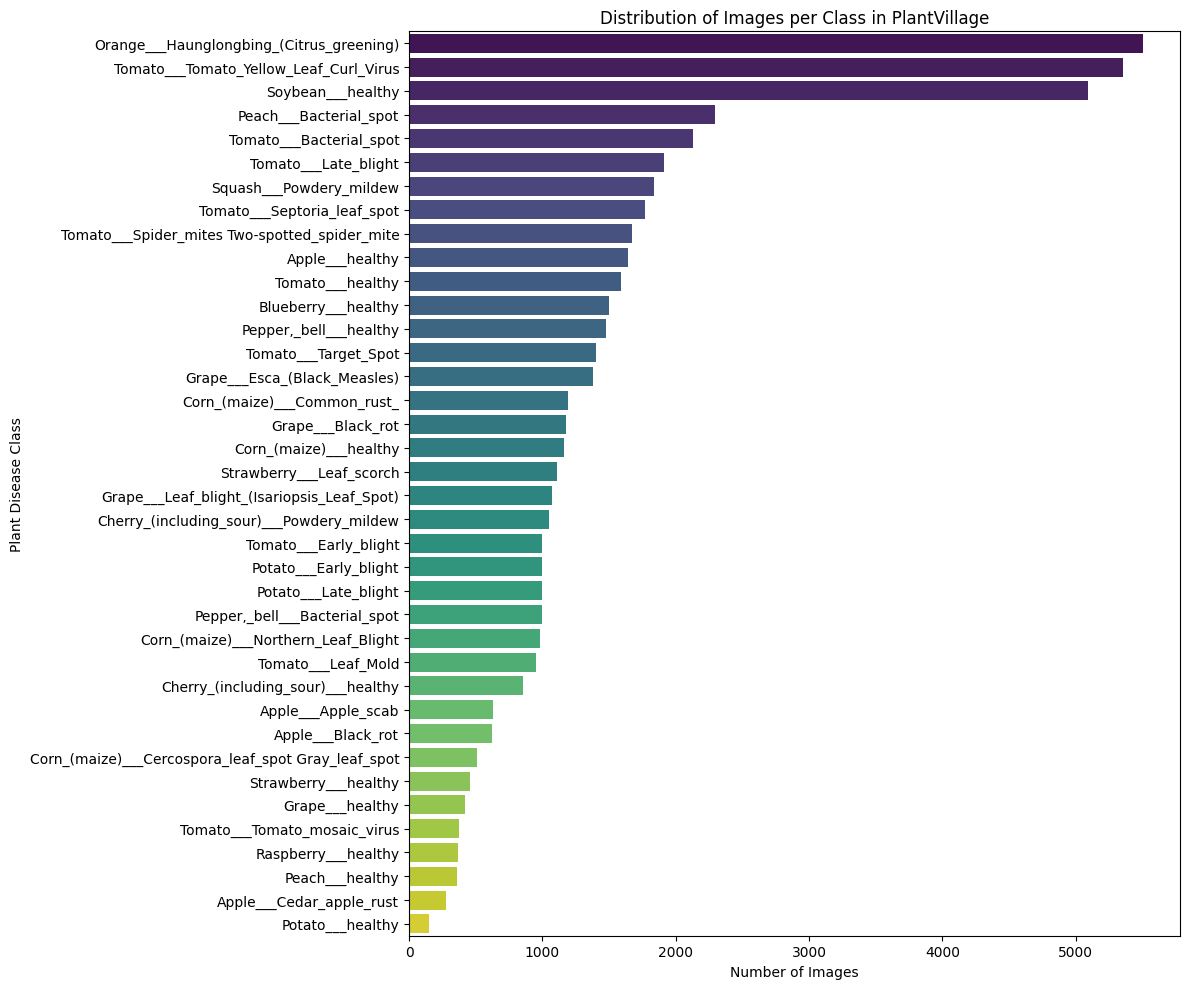

In [4]:
# 4. Visualize and Save Sorted Class Distribution
df_stats_sorted = df_stats.sort_values(by='Count', ascending=False)

plt.figure(figsize=(12, 10))

sns.barplot(
    y='Class', 
    x='Count', 
    data=df_stats_sorted, 
    order=df_stats_sorted['Class'], 
    hue='Class', 
    palette='viridis', 
    legend=False
)

plt.title('Distribution of Images per Class in PlantVillage')
plt.xlabel('Number of Images')
plt.ylabel('Plant Disease Class')
plt.tight_layout()
plt.show()

# Stats

## Geometric Check

In [5]:
def check_image_geometry(base_path):
    dims = []
    # Check a few samples from each folder to verify consistency
    for folder in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path)[:5]:
                img = cv2.imread(os.path.join(folder_path, file))
                if img is not None:
                    dims.append(img.shape)
    
    dim_df = pd.DataFrame(dims, columns=['Height', 'Width', 'Channels'])
    print("--- Geometric Summary ---")
    print(dim_df.value_counts())

# Run the check
check_image_geometry(base_path)

--- Geometric Summary ---
Height  Width  Channels
256     256    3           190
Name: count, dtype: int64


# Preprocessing

## Transformations

In [6]:
# 1. Define Transformations
# We add Augmentation for the Training set to prevent overfitting.
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 2. Load the Dataset
full_dataset = datasets.ImageFolder(root=base_path)

# 3. Split into Train (80%), Val (10%), and Test (10%)
# This ensures you have a separate test set for your final report
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_data, val_data, test_data = random_split(
    full_dataset, [train_size, val_size, test_size], 
    generator=torch.Generator().manual_seed(42)
)

# Apply transforms to specific splits
train_data.dataset.transform = train_transform
val_data.dataset.transform = val_test_transform
test_data.dataset.transform = val_test_transform

# 4. Create DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2)

print(f"Classes: {full_dataset.classes}")

Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___

## Dataset Split Summary 


In [7]:
# Print the final counts for each split
print("--- Dataset Split Summary ---")
print(f"Total Images:    {len(full_dataset)}")
print(f"Training set:    {len(train_data)} images")
print(f"Validation set:  {len(val_data)} images")
print(f"Testing set:     {len(test_data)} images")
print("-" * 30)

# Optional: Calculate percentages to verify the split
total = len(full_dataset)
print(f"Train/Val/Test Ratio: {len(train_data)/total:.0%}/{len(val_data)/total:.0%}/{len(test_data)/total:.0%}")

--- Dataset Split Summary ---
Total Images:    54305
Training set:    43444 images
Validation set:  5430 images
Testing set:     5431 images
------------------------------
Train/Val/Test Ratio: 80%/10%/10%


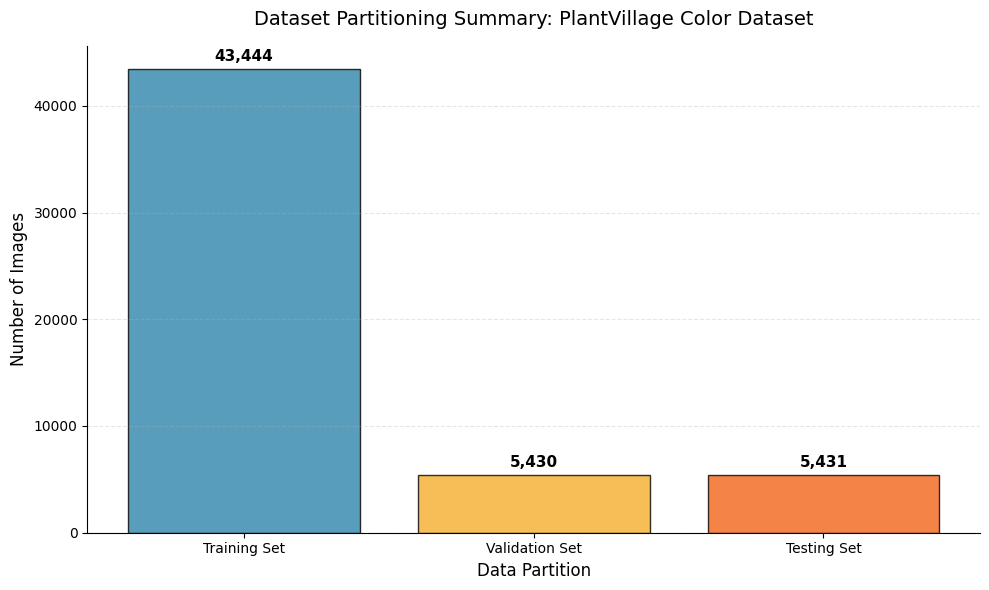

In [8]:
# 1. Prepare data for the plot
split_names = ['Training Set', 'Validation Set', 'Testing Set']
split_counts = [len(train_data), len(val_data), len(test_data)]
colors = ['#2E86AB', '#F6AE2D', '#F26419'] # Refined professional palette

# 2. Create the distribution plot
plt.figure(figsize=(10, 6))
bars = plt.bar(split_names, split_counts, color=colors, edgecolor='black', alpha=0.8)

# 3. Add formal labels and title
plt.title('Dataset Partitioning Summary: PlantVillage Color Dataset', fontsize=14, pad=15)
plt.ylabel('Number of Images', fontsize=12)
plt.xlabel('Data Partition', fontsize=12)

# 4. Add precise count labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + (max(split_counts) * 0.01),
             f'{int(height):,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 5. Final styling
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

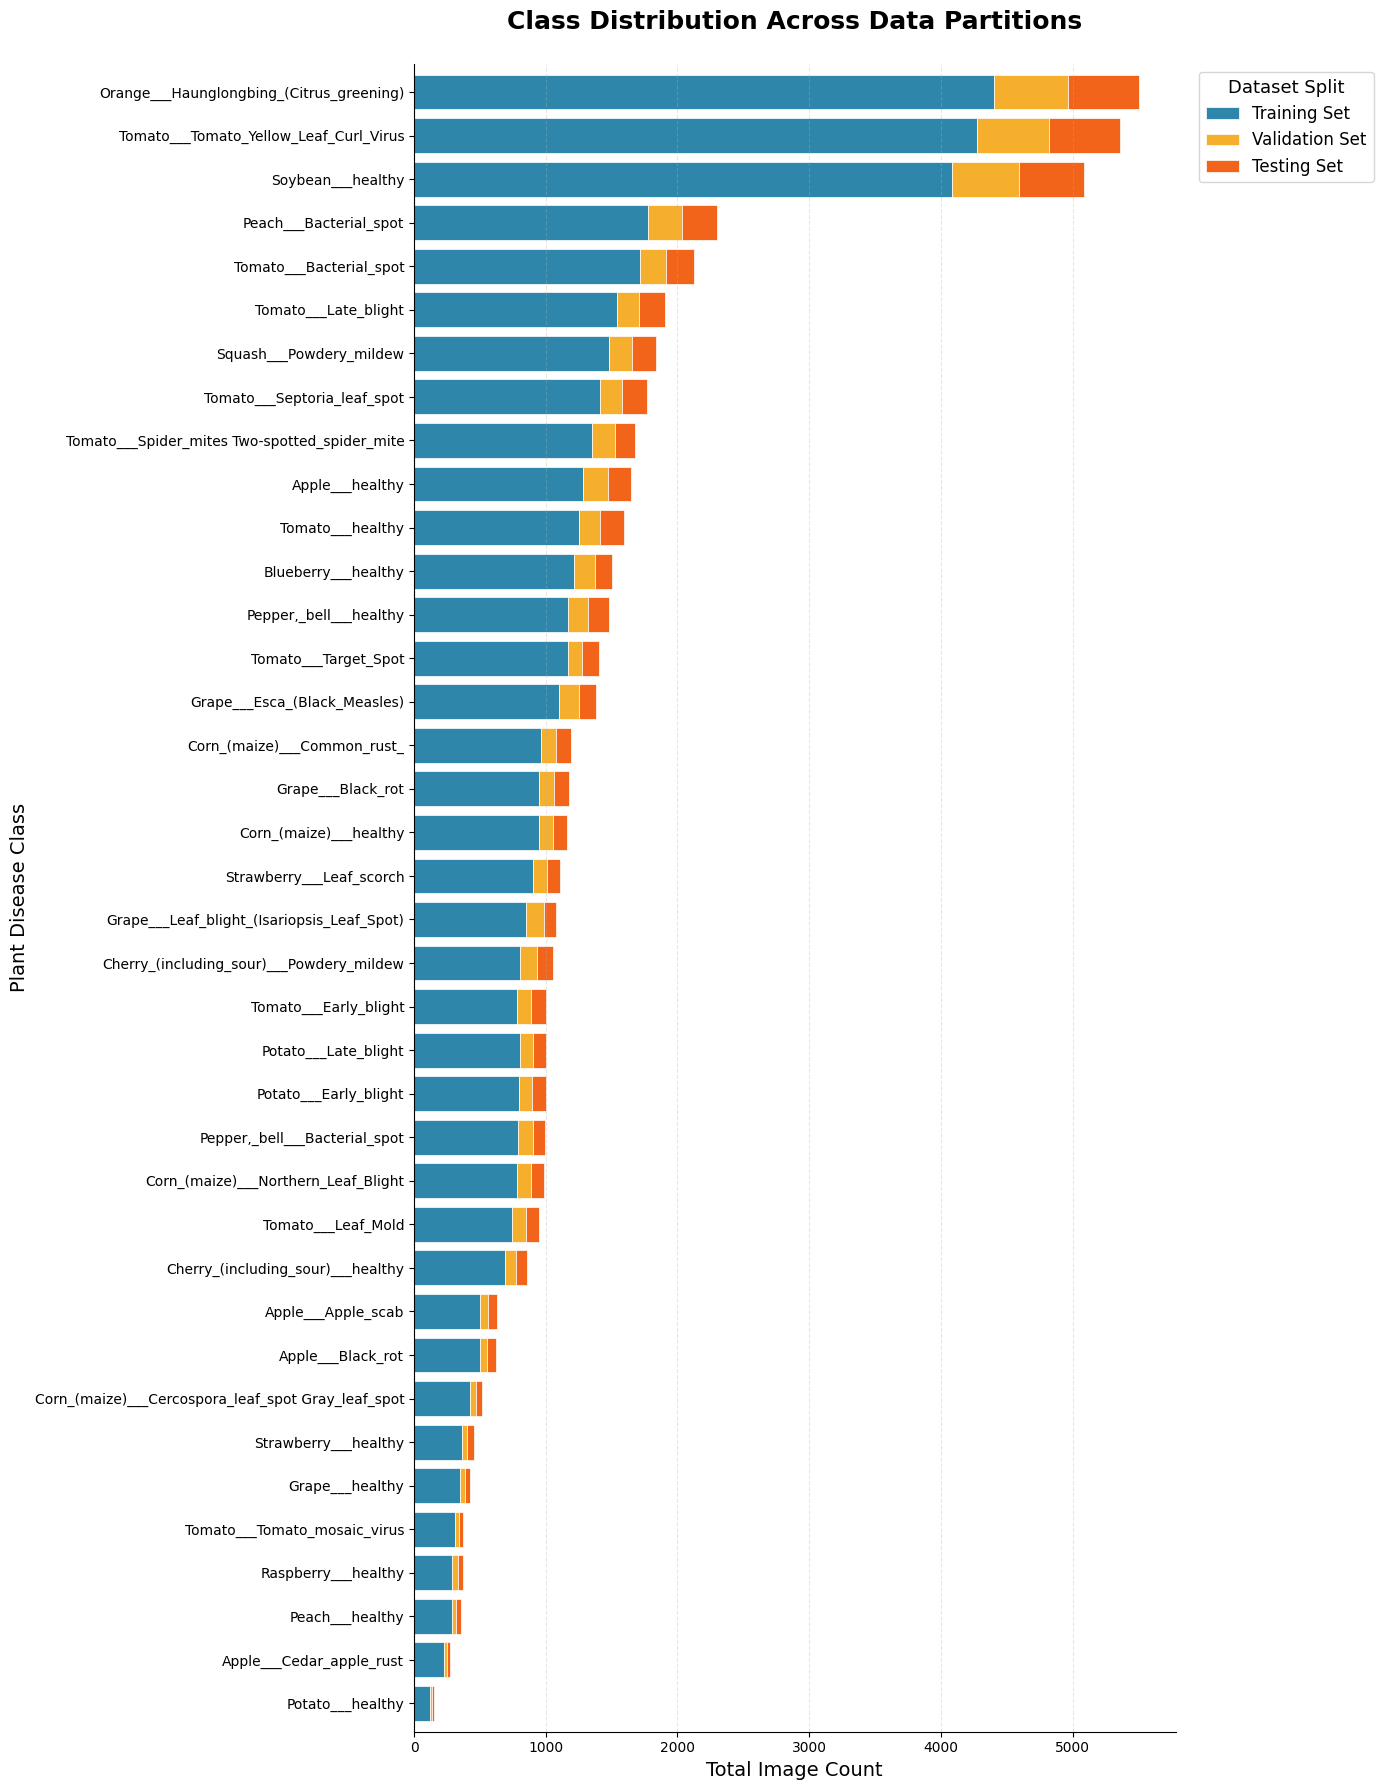

In [9]:
# 1. Extract class distribution for each split
def get_class_counts(subset, all_classes):
    # Extracting labels from subset indices
    labels = [subset.dataset.targets[i] for i in subset.indices]
    counts = pd.Series(labels).value_counts().sort_index()
    # Reindex to ensure all classes are present, filling missing with 0
    return [counts.get(i, 0) for i in range(len(all_classes))]

# 2. Prepare the data
class_names = full_dataset.classes
train_counts = get_class_counts(train_data, class_names)
val_counts = get_class_counts(val_data, class_names)
test_counts = get_class_counts(test_data, class_names)

# 3. Create DataFrame for plotting
df_stacked = pd.DataFrame({
    'Training Set': train_counts,
    'Validation Set': val_counts,
    'Testing Set': test_counts
}, index=class_names)

# 4. Sort by total to show the distribution imbalance clearly (Mindfulness)
df_stacked['Total'] = df_stacked.sum(axis=1)
df_stacked = df_stacked.sort_values(by='Total', ascending=True).drop(columns='Total')

# 5. Professional Horizontal Plotting
ax = df_stacked.plot(
    kind='barh', 
    stacked=True, 
    figsize=(14, 18), # Increased height for 38 classes readability
    color=['#2E86AB', '#F6AE2D', '#F26419'], 
    width=0.8,
    edgecolor='white',
    linewidth=0.5
)

# 6. Formal Aesthetics
plt.title('Class Distribution Across Data Partitions', fontsize=18, pad=25, fontweight='bold')
plt.xlabel('Total Image Count', fontsize=14)
plt.ylabel('Plant Disease Class', fontsize=14)

# Place legend outside so it doesn't cover the bars
plt.legend(title='Dataset Split', title_fontsize='13', fontsize='12', bbox_to_anchor=(1.02, 1), loc='upper left')

# Add subtle gridlines on the x-axis only
plt.grid(axis='x', linestyle='--', alpha=0.3)

# Remove top and right spines for a clean look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()